### !!!! DEPRECATED !!!

Use main **main.ipynb** now, it supports COLAB and local execution, and utils functions are defined in src directory.

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

In [4]:
from natsort import natsorted

# Loaded a set of images
root_dir = "../data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

test_images_dir = "../data/test_set_images/"
files = os.listdir(test_images_dir)
files = natsorted(files)
n = len(files)
print("Loading " + str(n) + " images")
test_imgs = [load_image(test_images_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_100.png
Loading 100 images
satImage_100.png
Loading 50 images
test_1.png


Image size = 400,400


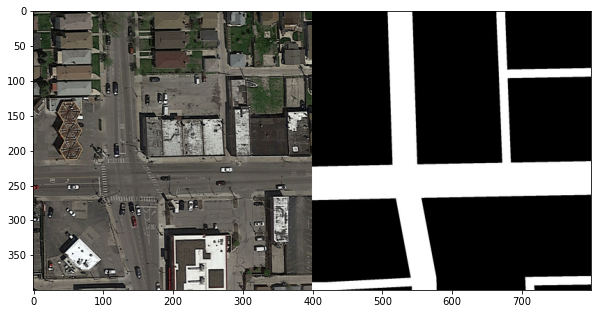

In [6]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [7]:
imgs = np.array(imgs)
gt_imgs = np.expand_dims(np.array(gt_imgs), -1)
test_imgs = np.array(test_imgs)
print(imgs.shape)
print(gt_imgs.shape)
print(test_imgs.shape)

(100, 400, 400, 3)
(100, 400, 400, 1)
(50, 608, 608, 3)


In [8]:
from sklearn.model_selection import train_test_split

seed = 1

train_images, test_images, train_masks, test_masks = train_test_split(imgs, gt_imgs, test_size=0.2, random_state=seed)
#del imgs, gt_imgs
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(80, 400, 400, 3)
(80, 400, 400, 1)
TEST SET
(20, 400, 400, 3)
(20, 400, 400, 1)


In [9]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from keras.layers.experimental.preprocessing import RandomCrop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanIoU
import keras

In [10]:
IMAGE_HEIGHT = IMAGE_WIDTH = 400
NUM_CHANNELS = 3

In [11]:
# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(test_images, augment=True, seed=seed)
mask_datagen.fit(test_masks, augment=True, seed=seed)

In [12]:
image_generator = image_datagen.flow(test_images, seed=seed)
mask_generator = mask_datagen.flow(test_masks, seed=seed)
train_generator = zip(image_generator, mask_generator)

In [13]:
inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
#s = Lambda(lambda x: x / 255) (inputs)

#cropped = RandomCrop(256, 256) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 400, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 400, 400, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
EPOCHS = 10
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

In [16]:
opt = keras.optimizers.Adam(LEARNING_RATE)
bce = tf.keras.losses.BinaryCrossentropy()
model.compile(
      optimizer=opt,
      loss=bce)#,
      #metrics=[iou_coef])

In [17]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [ ]:
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=500,
                    batch_size = BATCH_SIZE)

Epoch 1/10
500/500 [==============================] - 664s 1s/step - loss: 0.0894
Epoch 2/10
500/500 [==============================] - 663s 1s/step - loss: 0.0866
Epoch 3/10
500/500 [==============================] - 662s 1s/step - loss: 0.0848
Epoch 4/10
500/500 [==============================] - 661s 1s/step - loss: 0.0830
Epoch 5/10
500/500 [==============================] - 658s 1s/step - loss: 0.0820
Epoch 6/10
500/500 [==============================] - 657s 1s/step - loss: 0.0806
Epoch 7/10
500/500 [==============================] - 646s 1s/step - loss: 0.0797
Epoch 8/10
500/500 [==============================] - 644s 1s/step - loss: 0.0788
Epoch 9/10
500/500 [==============================] - 643s 1s/step - loss: 0.0778
Epoch 10/10
500/500 [==============================] - 645s 1s/step - loss: 0.0775


In [ ]:
#model.save("/content/drive/MyDrive/cs-433-project-2-team-afm/model_colab_20_epochs.h5")

In [18]:
model = load_model("model_colab_20_epochs.h5")

In [19]:
model.evaluate(test_images, test_masks)

1/1 [==============================] - 0s 2ms/step - loss: 0.1775


0.1775466650724411

In [20]:
predictions = model.predict(test_images, verbose=1)
predictions_train = model.predict(train_images)

1/1 [==============================] - 0s 7ms/step


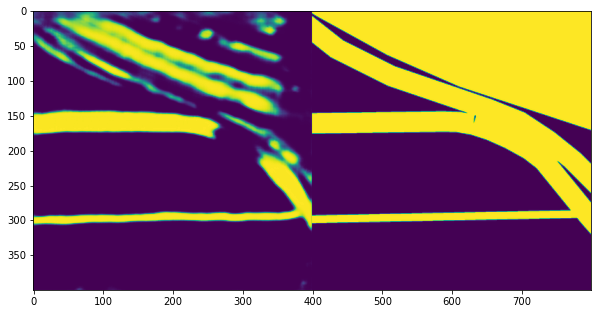

In [25]:
cimg = np.squeeze(concatenate_images(predictions_train[0], train_masks[0]))
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg)

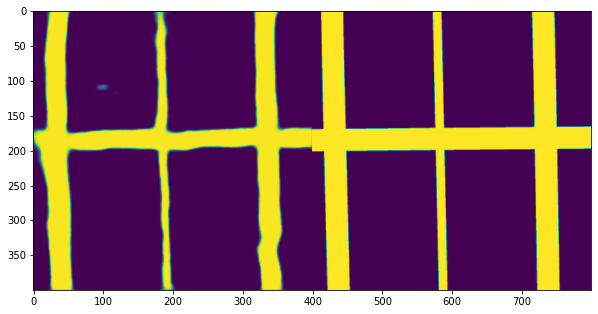

In [26]:
cimg = np.squeeze(concatenate_images(predictions[1], test_masks[1]))
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg)

In [27]:
def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

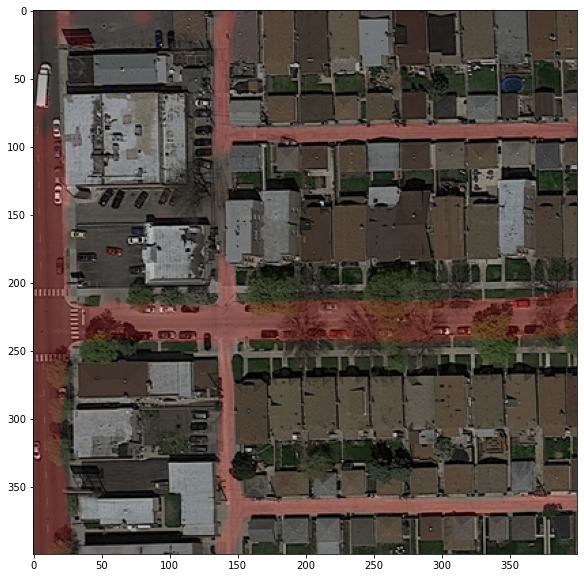

In [29]:
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(test_images[0], np.squeeze(predictions[0]))

plt.imshow(new_img)

In [37]:
# mask_to_submission.py

import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(im, img_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *images):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for index, image in enumerate(images[0:]):
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(image, index+1))


In [39]:
len(predictions)

20

In [38]:
submission_filename = 'dummy_submission.csv'
masks_to_submission(submission_filename, *predictions)